In [1]:
'''
Neural Network w/ graph-convolution layers w/ small N-body data
'''

'''
IMPORT N-BODY SIMULATIONS
'''
import glob
import struct
import numpy as np
DATA_PATH = '/home/evan/Data/nbody_simulations/' 
#DATA_PATH = '../data/'
# read simulation output into arrays of shape (b,N_p,6), b=batch size, N_p=set size=number of particles
def read_sim(file_list,N_part):
    batch = []
    for file_name in file_list:
        this_set = []
        with open(file_name, "rb") as f:
            for i in range(N_part*6):
                s = struct.unpack('=f',f.read(4))
                this_set.append(s[0])
        batch.append(this_set)
    batch = np.array(batch).reshape([len(file_list),N_part,6])  
    return batch

# z=0.4 and z=0.0
# replace path to simulations output
z20_files = glob.glob(DATA_PATH + 'N_1000/DM*/xv_dm.z=00.4000')
z00_files = glob.glob(DATA_PATH + 'N_1000/DM*/xv_dm.z=00.0000')
#z20_files = glob.glob('./data/N_10000/DM*/xv_dm.z=00.6000')
#z00_files = glob.glob('./data/N_10000/DM*/xv_dm.z=00.0000')


# number of particles
N_p = 16**3
batch_20 = read_sim(z20_files,N_p)
batch_00 = read_sim(z00_files,N_p)
print(batch_00.shape)


(1000, 4096, 6)


In [2]:
# normalize coordinates and velocities by their mean/std
def normalize(X_in):
    '''
    I believe the rescaling function for coordinates is wrong:
    current:   (x - min(x)) / max(x)
    should be: (x - min(x)) / (max(x) - min(x))
    
    are coordinates not normalized?
    velocities are unchanged
    '''
    X_1 = np.reshape(X_in,[-1,6])
    coo_min, coo_max = np.min(X_1[:,:3],axis=0), np.max(X_1[:,:3],axis=0)
    v_mean, v_std = np.mean(X_1[:,3:],axis=0), np.std(X_1[:,3:],axis=0)
    X_1[:,:3] = (X_1[:,:3] - coo_min) / (coo_max - coo_min)
    #X_1[:,:3] = (X_1[:,:3] - coo_min) / (coo_max)
    
    X_1[:,3:] = (X_1[:,3:]-v_mean)/v_std
    return np.reshape(X_1,[X_in.shape[0],X_in.shape[1],6])

def randomize(b1, b2):
    for i in range(b1.shape[0]):
        if np.random.rand() < .5:
            b1[i,...] = b1[i,:,[1,0,2,4,3,5]].T
            b2[i,...] = b2[i,:,[1,0,2,4,3,5]].T
        if np.random.rand() < .5:
            b1[i,...] = b1[i,:, [0,2,1,3,5,4]].T
            b2[i,...] = b2[i,:,[0,2,1,3,5,4]].T
        if np.random.rand() < .5:
            b1[i,...] = b1[i,:, [2,1,0,5,4,3]].T
            b2[i,...] = b2[i,:, [2,1,0,5,4,3]].T
    return b1, b2

# for simplicity I'm using mean/std normalization both for input and truth, just to get everything on the same scale
# normalization for the truth should be replaced with some constant factor normalization
batch_20 = normalize(batch_20)
batch_00 = normalize(batch_00)
print(batch_20.shape)
#batch_00, batch_20 = randomize(batch_00, batch_20)

(1000, 4096, 6)


In [3]:
'''
PRE-PROCESSING: nearest-neighbors and sparse adjacency
'''

import tensorflow as tf
import matplotlib.pyplot as plt
from random import randrange
from numpy import linalg as LA
%matplotlib inline

'''
SPARSE ADJACENCY MATRIX 
• scikit learn gives a CRS sparse adjacency for example, sparse TF takes COO. Use this for sparse X dense matmul in TF.
• also return adjacency lists and convert alist into index list to be used for generic normalizations (avg, max, etc)
'''

from sklearn.neighbors import kneighbors_graph
from sklearn.neighbors import NearestNeighbors


# # returns indices of non-zero elements, to be used in tf.SparseTensor
# def adjacency_COO(X_in,k):
#     shape_in = X_in.shape
#     X_out = np.zeros([shape_in[0],shape_in[1]*k,shape_in[2]])
#     for b in range(shape_in[0]):
#         X_out[b] = np.column_stack(kneighbors_graph(X_in[b],k,include_self=True).nonzero())
#     return X_out

# returns adjacency lists based on NN in coordinate space
def adjacency_list(X_in,k):
    shape_in = X_in.shape
    X_out = np.zeros([shape_in[0],shape_in[1],k],dtype=np.int32)
    for b in range(shape_in[0]):
        X_out[b] = kneighbors_graph(X_in[b,:,:3],k,include_self=True).indices.reshape([shape_in[1],k])
    return X_out

# tf.gather works for one batch and takes the adjacency list. Need to use gather_nd for the batched version.
# adjacency list to proper index list for gather_nd
def alist_to_indexlist(alist):
    b = alist.shape[0] # batch size
    n = alist.shape[1] # set size
    k = alist.shape[2] # number of nn
    id1 = np.reshape(np.arange(b),[b,1])
    id1 = np.tile(id1,n*k).flatten()
    out = np.stack([id1,alist.flatten()],axis=1)
    return out

n_NN = 30
# # example
# alist_04 = adjacency_list(batch_20[:10],n_NN)
# ilist_04 = alist_to_indexlist(alist_04)
# ilist_04.shape

/home/evan/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [4]:
'''
Subset layers
'''

'''
batch multiplications
'''
# T1=(b,n,k)|T2=(k,r)
# Tout=(b,n,r)
def left_mult(T1,T2):
    Tout = tf.einsum('ijl,lq->ijq',T1,T2)
    return Tout

"""
Notes on set layer:
- Initial repo had no activations
- preliminary tests show better performance with activations
"""
def set_layer(X_in,W,B,activation=tf.identity,dropout=False,keep_prob=1.,add=False):
    # get dimensions: mini-batch size, set size, input channels
    dim = X_in.get_shape()
    b = dim[0]; n = dim[1]; k = dim[2]
    # output channels
    k_out = tf.shape(W)[1] 
    # process input
    max_ = tf.reduce_max(X_in,axis=1,keep_dims=True)
    mean_ = tf.reduce_mean(X_in,axis=1,keep_dims=True)
    X_1 = X_in - mean_ #tf.matmul(tf.ones([b,n,1],tf.float32),mean_)
    #X_2 = tf.reshape(X_1,[b*n,k])
    #X_3 = tf.matmul(X_2,W) + B
    out = left_mult(X_1, W) + B
    if add:
        out = out + X_1
    #X_4 = tf.reshape(activation(X_3),[b,n,k_out])
    #out = X_4
    # dropout (simultaneous along set dimension)
    if dropout:
        out = tf.nn.dropout(out,keep_prob,noise_shape=[b,1,k_out])
    out = activation(out)
    return out

    
'''
SUBSET LAYER w/ ADJACENCY (graph-convolution)
max/avg normalization, index_list = nn
'''
def graph_subset_layer_beta(X_in,index_list,L,G,space_dim,NN_dim,activation=tf.identity,dropout=True,keep_prob=.5):
    dim = tf.shape(X_in)
    b = dim[0]; n = dim[1]
    X_1 = tf.reshape(tf.gather_nd(X_in,index_list),[b,n,NN_dim,space_dim])
    X_2 = tf.reduce_mean(X_1,axis=2)
    #X_2 = tf.reduce_max(X_1,axis=2)
    X_3 = left_mult(X_in,L) + left_mult(X_2,G)
    X_4 = activation(X_3)
    X_out = X_4
    # dropout (simultaneous along set dimension)
    if dropout:
        k_out = tf.shape(L)[1]
        X_out = tf.nn.dropout(X_4,keep_prob,noise_shape=[b,1,k_out])
    return  X_out

'''
Mini-batch
'''
def next_minibatch(in_list,batch_size):
    if all(len(i) == len(in_list[0]) for i in in_list) == False:   
        raise ValueError('Inputs do not have the same dimension')
    index_list = np.random.permutation(len(in_list[0]))[:batch_size]#np.random.randint(len(in_list[0]), size=batch_size)
    out = list()
    rands = np.random.rand(6)
    shift = np.random.rand(batch_size,3)
    for k in range(len(in_list)):
        tmp = in_list[k][index_list]
        if rands[0] < .5:
            tmp = tmp[:,:,[1,0,2,4,3,5]]
        if rands[1] < .5:
            tmp = tmp[:,:, [0,2,1,3,5,4]]
        if rands[2] < .5:
            tmp = tmp[:,:, [2,1,0,5,4,3]]
        if rands[3] < .5:
            tmp[:,:,0] = 1 - tmp[:,:,0]
            tmp[:,:,3] = -tmp[:,:,3]
        if rands[4] < .5:
            tmp[:,:,1] = 1 - tmp[:,:,1]
            tmp[:,:,4] = -tmp[:,:,4]
        if rands[5] < .5:
            tmp[:,:,2] = 1 - tmp[:,:,2]
            tmp[:,:,5] = -tmp[:,:,5]
            
        tmploc = tmp[:,:,:3]
        tmploc += shift[:,None,:]
        gt1 = tmploc > 1
        tmploc[gt1] = tmploc[gt1] - 1
        tmp[:,:,:3] = tmploc
        out.append(tmp)
    return out

In [5]:
'''
Neural Network
'''
# initialize params
def w_variable(shape,name=None):
    initial = tf.truncated_normal(shape, stddev=1e-3)
    if name is None:
        out = tf.Variable(initial)
    else:
        out = tf.Variable(initial, name=name)
    return out

# def b_variable(shape):
#     initial = tf.constant(1e-2, shape=shape)
#     return tf.Variable(initial)

# in/out channels
k_in = 6
k_out = 3

# dropout probability
keep_prob = tf.placeholder(tf.float32)

# input 
X_input = tf.placeholder(tf.float32, shape=[None,N_p,k_in], name='X_input')
# truth
X_truth = tf.placeholder(tf.float32, shape=[None,N_p,k_in], name='X_truth')
# info about nn, in the form of a indexlist, has shape (batch_size*set_size*nn,2)
#index_list = tf.placeholder(tf.int32, shape=[None,2], name='index_list') 


'''
Layer 1
'''
k1 = 128 # output channels
L1 = w_variable([k_in,k1],name='L1')
G1 = w_variable([1,1,k1],name='G1')
out1 = set_layer(X_input,L1,G1,activation=tf.nn.elu,dropout=False)


'''
Layer 2
'''
k2 = 128 # output channels
L2 = w_variable([k1,k2],name='L2')
G2 = w_variable([1,1,k2],name='G2')
out2 = set_layer(out1,L2,G2,activation=tf.nn.elu,dropout=False,add=True)

'''
Layer 3
'''
k3 = 128 # output channels
L3 = w_variable([k2,k3],name='L3')
G3 = w_variable([1,1,k3],name='G3')
out3 = set_layer(out2,L3,G3,activation=tf.nn.elu,dropout=False,add=True)


'''
Layer 4
'''
k4 = 128 # output channels
L4 = w_variable([k3,k4],name='L4')
G4 = w_variable([1,1,k4],name='G4')
out4 = set_layer(out3,L4,G4,activation=tf.nn.elu,dropout=False,add=True)


'''
Layer 5
'''
k5 = 128 # output channels
L5 = w_variable([k4,k5],name='L5')
G5 = w_variable([1,1,k5],name='G5')
out5 = set_layer(out4,L5,G5,activation=tf.nn.elu,dropout=False,add=True)


'''
Output layer
'''
L_out = w_variable([k5,k_out],name='L_out')
G_out = w_variable([1,1,k_out],name='G_out')
readout = set_layer(out5,L_out,G_out,activation=tf.identity,dropout=False)

readout += X_input[:,:,:3]
#readout_v = readout#[:,:,3:] 
readout_x = readout#[:,:,:3] 
gt_one = ((tf.sign(readout_x - 1) + 1)/2)
ls_zero = -(tf.sign(readout_x) - 1)/2
rest = 1 - gt_one - ls_zero
readout_x =  rest * readout_x + gt_one *(readout_x - 1) + ls_zero*(1 + readout_x)

'''
Loss Function
'''
X_truth_loc = X_truth[:,:,:3]
X_truth_v = X_truth[:,:,3:]

dist = tf.minimum(tf.square(readout_x-X_truth_loc), tf.square(readout_x - (1 + X_truth_loc)))
dist = tf.minimum(dist, tf.square((1 + readout_x) - X_truth_loc))
#dist_v = tf.minimum(dist, tf.square((1 + readout_v) - X_truth_v))
#dist = tf.square(readout-X_truth_loc)
# L2-distance 
# I believe the second mean is redundant
loss = tf.reduce_mean(tf.reduce_mean(tf.reduce_sum(dist,axis=2),axis=1),axis=0,name='loss')
#loss += tf.reduce_mean(tf.reduce_mean(tf.reduce_sum(dist_v,axis=2),axis=1),axis=0,name='loss')

'''
Optimization
'''
train_step = tf.train.AdamOptimizer(1e-3).minimize(loss)

KeyboardInterrupt: 

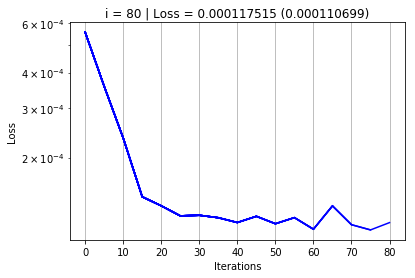

In [6]:
'''
Training
'''
saver = tf.train.Saver()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))
sess.run(tf.global_variables_initializer())
import time
from IPython import display

# iterations
n_iter = 500

# minibatch size
mb_size = 64
t = list()
loss_vals = list()
plt.clf()
for i in range(n_iter):
    # get input and truth minibatch and get nn indexlist
    batch = next_minibatch([batch_20,batch_00],mb_size)
    #alist = adjacency_list(batch[0],n_NN)
    #ilist = alist_to_indexlist(alist)
    # plot loss evolution
    if i%5 == 0:
        t.append(i)
        this_loss = sess.run(loss,feed_dict={X_input: batch[0], X_truth: batch[1], keep_prob: .5})
        loss_vals.append(this_loss)
        if this_loss < 0.000001:
            print('Stopped at loss = ', this_loss)
            break
        plt.yscale('log')
        plt.grid(True)
        plt.plot(t,loss_vals,'b-')
        #plt.scatter(t,loss_vals,color='black',s=20,alpha=.3)
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.grid(True)
        if len(t) > 1:
            plt.title('i = '+str(t[-1])+' | Loss = '+str(loss_vals[-1])+' ('+str(loss_vals[-2])+')')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        time.sleep(1)    
        
    train_step.run(feed_dict={X_input: batch[0], X_truth: batch[1], keep_prob: .5})

In [26]:
saver.save(sess, './models/FixRescaleNorm')

'./models/FixRescaleNorm'

('loss.shape: ', (2, 150))


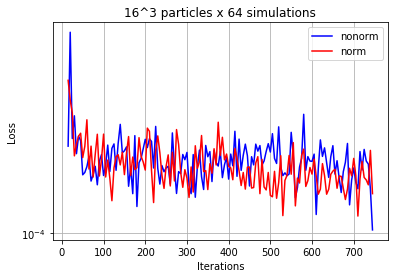

In [28]:
'''
save learning curves
'''
# Save loss vals
cur_loss = np.array([t,loss_vals])
print('loss.shape: ',cur_loss.shape)
np.save('./saved_data_smallNbody/FixRescaleNorm',cur_loss)

'''
------------------
batch_size|z_in|z_final|n_NN|depth|channels
------------------
------------------ MINE
batch_size|z_in|z_final|n_iter|n_layers|channels
------------------

'''

# # 64|2.0|0.0|1000|6|128
# NO ACTIVATION
loss1 = np.load('./saved_data_smallNbody/FixRescaleNorm.npy')
loss2 = np.load('./saved_data_smallNbody/FixRescaleNorm.npy')
"""
# # 100|2.0|0.0|30|2|64
# # 100|2.0|0.0|30|2|128 >> no substantial improv
# loss_1 = np.load('./saved_data_smallNbody/loss_1.npy')

# # 100|2.0|0.0|80|2|64
# loss_3 = np.load('./saved_data_smallNbody/loss_3.npy')

# # 100|2.0|0.0|30|3|64
# loss_4 = np.load('./saved_data_smallNbody/loss_4.npy')

# # 100|2.0|0.0|30|2|64
# loss_5 = np.load('./saved_data_smallNbody/loss_5.npy')

# 100|2.0|0.0|30|3|64
loss_6 = np.load('./saved_data_smallNbody/loss_6.npy')

# 100|2.0|0.0|30|2|64
loss_7 = np.load('./saved_data_smallNbody/loss_7.npy')

# 100|2.0|0.0|30|4|64
loss_8 = np.load('./saved_data_smallNbody/loss_8.npy')

# 100|2.0|0.0|30|3|64
loss_9 = np.load('./saved_data_smallNbody/loss_9.npy')
# 100|2.0|0.0|30|3|64
loss_10 = np.load('./saved_data_smallNbody/loss_10.npy')
ind = []
for i in range(752):
    if i%4==0:
        ind.append(i)
loss_6X = loss_6[:,ind]
loss_7X = loss_7[:,ind]

"""



'''
------------------
loss plots
------------------
'''
"""
plt.yscale('log')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.xlim([-100,3800])
d1_a = plt.scatter(loss_7X[0],loss_7X[1],color='blue',s=20,alpha=.3)
d1_b =    plt.plot(loss_7X[0],loss_7X[1],color='black')
d2_a = plt.scatter(loss_6X[0],loss_6X[1],color='red',s=20,alpha=.3)
d2_b =    plt.plot(loss_6X[0],loss_6X[1],color='black')
#d3_a = plt.scatter(loss_4[0],loss_4[1],color='green',s=20,alpha=.3)
#d3_b = plt.plot(loss_4[0],loss_4[1],color='black')
plt.title('16^3 particles x 100 simulations')
plt.legend((d1_a,d2_a),('30NN x 64 ch x 2 hl','30NN x 64 ch x 3 hl'),scatterpoints=1,loc='upper right',fontsize=10)
plt.show()
"""

loss1 = loss1[:,3:]
loss2 = loss2[:,3:]
plt.yscale('log')
plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Loss')
#plt.xlim([-100,3800])
#d1_a = plt.scatter(loss1[0],loss1[1],color='blue',s=20,alpha=.3)
d1_b =    plt.plot(loss1[0,],loss1[1,],color='blue', label='nonorm')
#d2_a = plt.scatter(loss2[0],loss2[1],color='red',s=20,alpha=.3)
d2_b =    plt.plot(loss2[0,],loss2[1,],color='red', label='norm')
#d3_a = plt.scatter(loss_4[0],loss_4[1],color='green',s=20,alpha=.3)
#d3_b = plt.plot(loss_4[0],loss_4[1],color='black')
plt.title('16^3 particles x 64 simulations')
#plt.legend((d1_a,d2_a),('No','With'),scatterpoints=1,loc='upper right',fontsize=10)
plt.legend()
plt.show()




In [22]:
loss1[1]

array([ 0.00068667,  0.00067536,  0.00066918,  0.00065529,  0.00066536,
        0.00066974,  0.00067867,  0.00065656,  0.00069383,  0.00069482,
        0.00067595,  0.0006699 ,  0.00066815,  0.00066278,  0.00067456,
        0.00064784,  0.00067159,  0.00064373,  0.0007157 ,  0.00066283,
        0.00063799,  0.00065645,  0.00067371,  0.00067521,  0.00067968,
        0.00066291,  0.00067076,  0.0006695 ,  0.00066729,  0.00065898,
        0.00068268,  0.00064853,  0.00067917,  0.00066612,  0.00069046,
        0.00066442,  0.00064501,  0.00069932,  0.00065005,  0.00064781,
        0.00069127,  0.00065218,  0.00069417,  0.00068438,  0.00067034,
        0.00068017,  0.00068907,  0.00070789,  0.00066337,  0.00066705,
        0.0006776 ,  0.00066293,  0.0006515 ,  0.00066041,  0.00066883,
        0.00066082,  0.00064853,  0.00070103,  0.00066689,  0.00070125,
        0.00066101,  0.00063774,  0.00065215,  0.00065145,  0.00063602,
        0.00066755,  0.00065003,  0.00068271,  0.00066651,  0.00

In [27]:
# 2D slices from the training set
test = next_minibatch([batch_20,batch_00],10)
#alist_test = adjacency_list(test[0],n_NN)
#ilist_test = alist_to_indexlist(alist_test)
out_test = sess.run(readout,feed_dict={X_input: test[0], keep_prob: .8})
test_loss = sess.run(loss,feed_dict={X_input: test[0], X_truth: test[1], keep_prob: .8})
print('Loss = ',test_loss)

# select random points
ind = np.random.randint(N_p, size=10)
test_in = test[0][:,ind,:]
test_truth = test[1][:,ind,:]
test_out = out_test[:,ind,:]
"""

fig = plt.figure()
fig.set_size_inches(15,5)
fig.suptitle('Coordinates [300 particles sample]', fontsize=14)
xylims = [0,1]
slices=np.array([[0,1],[0,2],[1,2]])
example = 0
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,aspect='equal')
    ax.set_ylim(xylims)
    ax.set_xlim(xylims)
    inp = ax.scatter(test_in[example,:,slices[i][0]],test_in[example,:,slices[i][1]],color='blue',s=20,alpha=.3)
    tru = ax.scatter(test_truth[example,:,slices[i][0]],test_truth[example,:,slices[i][1]],color='red',s=20,alpha=.3)
    out = ax.scatter(test_out[example,:,slices[i][0]],test_out[example,:,slices[i][1]],edgecolors='black',s=80,facecolors='none')
    plt.legend((inp,tru,out),('input','expected', 'predicted'),scatterpoints=1,loc='upper right',fontsize=8)
    plt.xticks(np.arange(xylims[0],xylims[1]+.1,.5))
    plt.yticks(np.arange(xylims[0],xylims[1]+.1,.5))
    plt.grid(True)
plt.show()

fig = plt.figure()
fig.set_size_inches(15,5)
fig.suptitle('Velocities [300 particles sample]', fontsize=14)
xylims = [0,1]
slices=np.array([[3,4],[3,5],[4,5]])
example = 0
for i in range(3):
    ax = fig.add_subplot(1,3,i+1,aspect='equal')
    ax.set_ylim(xylims)
    ax.set_xlim(xylims)
    inp = ax.scatter(test_in[example,:,slices[i][0]],test_in[example,:,slices[i][1]],color='blue',s=20,alpha=.3)
    tru = ax.scatter(test_truth[example,:,slices[i][0]],test_truth[example,:,slices[i][1]],color='red',s=20,alpha=.3)
    out = ax.scatter(test_out[example,:,slices[i][0]],test_out[example,:,slices[i][1]],edgecolors='black',s=80,facecolors='none')
    plt.legend((inp,tru,out),('input','expected', 'predicted'),scatterpoints=1,loc='upper right',fontsize=8)
    plt.xticks(np.arange(xylims[0],xylims[1]+.1,.5))
    plt.yticks(np.arange(xylims[0],xylims[1]+.1,.5))
    plt.grid(True)
plt.show()
"""

('Loss = ', 0.00059852563)


"\n\nfig = plt.figure()\nfig.set_size_inches(15,5)\nfig.suptitle('Coordinates [300 particles sample]', fontsize=14)\nxylims = [0,1]\nslices=np.array([[0,1],[0,2],[1,2]])\nexample = 0\nfor i in range(3):\n    ax = fig.add_subplot(1,3,i+1,aspect='equal')\n    ax.set_ylim(xylims)\n    ax.set_xlim(xylims)\n    inp = ax.scatter(test_in[example,:,slices[i][0]],test_in[example,:,slices[i][1]],color='blue',s=20,alpha=.3)\n    tru = ax.scatter(test_truth[example,:,slices[i][0]],test_truth[example,:,slices[i][1]],color='red',s=20,alpha=.3)\n    out = ax.scatter(test_out[example,:,slices[i][0]],test_out[example,:,slices[i][1]],edgecolors='black',s=80,facecolors='none')\n    plt.legend((inp,tru,out),('input','expected', 'predicted'),scatterpoints=1,loc='upper right',fontsize=8)\n    plt.xticks(np.arange(xylims[0],xylims[1]+.1,.5))\n    plt.yticks(np.arange(xylims[0],xylims[1]+.1,.5))\n    plt.grid(True)\nplt.show()\n\nfig = plt.figure()\nfig.set_size_inches(15,5)\nfig.suptitle('Velocities [300 par

In [28]:
'''
Save/load full prediction on training batch_20
'''
batch_20_out = np.zeros([mb_size,4096,6])

for i in range(10):
    batch_in = batch_20[i*10:(i+1)*10]
    alist_in = adjacency_list(batch_in,n_NN)
    ilist_in = alist_to_indexlist(alist_in)
    out = sess.run(readout,feed_dict={X_input: batch_in, keep_prob: 1.})
    batch_20_out[i*10:(i+1)*10] = out    

np.save('./saved_data/batch_20_out',batch_20_out)
batch_20_out = np.load('./saved_data/batch_20_out.npy')

ValueError: could not broadcast input array from shape (10,4096,3) into shape (10,4096,6)

In [ ]:
'''
Notes:

• explore depth/learning rate
• augment input w/ rotations and shifts
• more particles + larger training set
• compare power spectra
• 3D visualization

• try subsets instead of just GC, need to fix normalization
• batches with different redshifts

• Code: make it more compact, define wrapper for the network for example, save/restore models using tf
'''

In [29]:
'''
3D visualization
'''
import pylab as plt
from mayavi import mlab


def volumize_ptc(datain,# n x 3
                 opacity=.5, labels=None,
                 color=(1,0,0),
                 frame=True, row=0, col=0,
                 show=True,
                 figure=None,
                 proj=(False,True,True),
                 shadow=(False,True,True),
                 mode='point',
                 scale_factor=.01,
                 filename=None,
                 normalize=False,
):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = datain.copy()
    if normalize:
        data -= np.min(data, keepdims=True)
        data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj,yproj,zproj = proj
    xshadow,yshadow,zshadow=shadow
    if labels is None:
        pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))

    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))


    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show:
            mlab.clf()
    if show:
        mlab.show()

In [31]:
'''
3D visualization
'''
import pylab as plt
from mayavi import mlab


def volumize_arrow(datain,# n x 3
                   arrow, #nx3
                 opacity=.5, labels=None,
                 color=(1,0,0),
                 frame=True, row=0, col=0,
                 show=True,
                 figure=None,
                 proj=(False,True,True),
                 shadow=(False,True,True),
                 mode='point',
                 scale_factor=.001,
                 filename=None,
                 normalize=False,
):
    if figure is None:
        figure = mlab.figure(1, size=(400, 400), bgcolor=(0, 0, 0), fgcolor=(1, 0, 0))

    data = datain.copy()
    if normalize:
        data -= np.min(data, keepdims=True)
        data /= np.max(data, keepdims=True)
    data[:,0] += np.float(col)
    data[:,1] += np.float(row)
    xproj,yproj,zproj = proj
    xshadow,yshadow,zshadow=shadow
    if labels is None:
        #pts = mlab.points3d(data[:,0], data[:,1], data[:,2], mode=mode, color=color, opacity=opacity, figure=figure, scale_factor=scale_factor)
        #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
        pts = mlab.quiver3d(data[:,0], data[:,1], data[:,2], arrow[:,0], arrow[:,1], arrow[:,2], color=color, opacity=opacity, figure=figure, mode=mode)
    else:
        for l in np.unique(labels):
            color = tuple(list(np.random.rand(3)))
            ind = (labels == l).nonzero()[0]
            mlab.pipeline.volume(mlab.points3d(data[ind,0], data[ind,1], data[ind,2], mode=mode, color=color, opacity=opacity))
    if frame:
        r_points = np.array([0,1,1,0,0,1,1,1,1,1,0,0,0,1,1,0,0,0]) + row + .0
        c_points = np.array([0,0,1,1,1,1,0,0,1,1,1,0,0,0,0,0,0,1]) + col +.0
        d_points = np.array([0,0,0,0,1,1,1,0,0,1,1,1,0,0,1,1,0,0]) +.0
        mlab.plot3d(c_points, r_points, d_points, representation='surface',tube_radius=.003, line_width=1, figure=figure, opacity=.7, color=(1,1,1))


    #mlab.pipeline.volume(mlab.pipeline.gaussian_splatter(pts, figure=figure))
    mlab.view(azimuth=20, elevation=70, distance=3, focalpoint=None, roll=None, reset_roll=True, figure=figure)    
    if filename is not None:
        mlab.savefig(filename, size=(500,500), figure=figure, magnification='auto') 
        if not show:
            mlab.clf()
    if show:
        mlab.show()

In [33]:
#test = batch_20[0,:50,:3]
#print test.shape
#out_test2 = sess.run(readout,feed_dict={X_input: out_test, keep_prob: .8})
#out_test3 = sess.run(readout,feed_dict={X_input: out_test2, keep_prob: .8})

j = 1
#velocity=test[0][j,:,3:] 
#test1 = batch_00[j,:,:3]
#velocity=batch_00[j,:,3:]
#test2 = batch_00[j+3,:,:3]#l1 = np.array([0 for i in range(25)]+[1 for i in range(25)])
test1 = test[0][j,:,:3]
test2 = test[1][j,:,:3]#l1 = np.array([0 for i in range(25)]+[1 for i in range(25)])
test3 = out_test[j,:,:3]
#test4 = out_test2[j,:,:3]
#test5 = out_test3[j,:,:3]

velocity = test[0][j,:,3:]
fig = mlab.figure(1, size=(400, 400), bgcolor=(1, 1, 1), fgcolor=(1, 0, 0))
volumize_ptc(test1,figure=fig, opacity=.9, show=True, mode='point', color=(.1,0,0))
#volumize_ptc(test3,figure=fig, opacity=.9, show=True, mode='point', color=(.1,0,0))
#volumize_ptc(test2,figure=fig, opacity=.5, show=False, mode='point', color=(0,0,1))
#volumize_ptc(test3,figure=fig, opacity=.5, show=True, mode='point', color=(0,1,0))
#volumize_ptc(test4,show = True, figure=fig, opacity=.5, color=(0,0,1), mode='point')
#volumize_arrow(test1, (test2 - test1), figure=fig, opacity=.3, show=False, mode='arrow')
#volumize_arrow(test1, (test3 - test1), show = False, figure=fig, opacity=.3, color=(0,1,0), mode='arrow')
#volumize_arrow(test1, velocity, show = True, figure=fig, opacity=.3, color=(0,0,1), mode='2darrow')


ERROR:root:An unexpected error occurred while tokenizing input
The following traceback may be corrupted or invalid
The error message is: ('EOF in multi-line string', (1, 0))



ImportError: Could not import backend for traits
_______________________________________________________________________________
Make sure that you have either the TraitsBackendWx or the TraitsBackendQt
projects installed. If you installed Mayavi with easy_install, try
easy_install <pkg_name>. easy_install Mayavi[app] will also work.

If you performed a source checkout, be sure to run 'python setup.py install'
in Traits, TraitsGUI, and the Traits backend of your choice.

Also make sure that either wxPython or PyQT is installed.
wxPython: http://www.wxpython.org/
PyQT: http://www.riverbankcomputing.co.uk/software/pyqt/intro
